In [65]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.losses import MeanSquaredError
from keras.optimizers import Adam

In [66]:
DATA_PATH = 'data_cars/'
all_files = os.listdir(DATA_PATH)

all_dataframes = []
for index, file in enumerate(all_files):
    print(f"Reading file: {file}")
    file_name = file.split('.')[0]
    df = pd.read_csv(DATA_PATH + file, sep=';')

    df['date'] = pd.to_datetime(df[file_name], format='%Y-%m-%d %H:%M')
    df = df.drop(columns=[file_name])

    df = df.set_index('date')
    df.columns = [f"{file_name}_{col}" for col in df.columns if col != 'date']
    all_dataframes.append(df)
    print(f"Finished reading file: {file}, shape = {df.shape}")

combined_df = pd.concat(all_dataframes, axis=1)
combined_df.fillna(method='ffill', inplace=True)
combined_df['hour'] = combined_df.index.hour
combined_df['day_of_week'] = combined_df.index.dayofweek

data = np.array(combined_df, dtype=float)[:, :-2]

singleScaler = StandardScaler()
singleSensorData = singleScaler.fit_transform(data[:, 0].reshape(-1,1))
scaler = StandardScaler()
data = scaler.fit_transform(data)

Reading file: K120.csv
Finished reading file: K120.csv, shape = (2880, 7)
Reading file: K134.csv
Finished reading file: K134.csv, shape = (2880, 7)
Reading file: K140.csv
Finished reading file: K140.csv, shape = (2880, 5)
Reading file: K159.csv
Finished reading file: K159.csv, shape = (2880, 11)
Reading file: K405.csv
Finished reading file: K405.csv, shape = (2880, 19)
Reading file: K406.csv
Finished reading file: K406.csv, shape = (2880, 8)
Reading file: K701.csv
Finished reading file: K701.csv, shape = (2880, 7)
Reading file: K702.csv
Finished reading file: K702.csv, shape = (2880, 8)
Reading file: K703.csv
Finished reading file: K703.csv, shape = (2880, 10)
Reading file: K709.csv
Finished reading file: K709.csv, shape = (2880, 17)
Reading file: K711.csv
Finished reading file: K711.csv, shape = (2880, 31)


In [67]:
def splitSequence(seq, n_steps):

    #Declare X and y as empty list
    X = []
    y = []

    for i in range(len(seq)):
        #get the last index
        lastIndex = i + n_steps

        #if lastIndex is greater than length of sequence then break
        if lastIndex > len(seq) - 1:
            break

        # Create input and output sequence
        # Last 2 columns are time of day and day of week
        seq_X, seq_y = seq[i:lastIndex], seq[lastIndex]

        #append seq_X, seq_y in X and y list
        X.append(seq_X)
        y.append(seq_y)
        #Convert X and y into numpy array
    X = np.array(X)
    y = np.array(y)

    return X,y

In [68]:
num_of_steps = data.shape[0]
train_size = 0.6
val_size = 0.15
shuffle = False
look_back = 80

x, y = splitSequence(data, look_back)
x_one, y_one = splitSequence(singleSensorData, look_back)

if shuffle:
    idx = np.random.permutation(len(x))
    x,y = x[idx], y[idx]

num_train = int(num_of_steps * train_size)
num_val = int(num_of_steps * val_size)

x_train, y_train = x[:num_train], y[:num_train]
x_val, y_val = x[num_train:num_train + num_val], y[num_train:num_train + num_val]
x_test, y_test = x[num_train + num_val:], y[num_train + num_val:]


x_train_single, y_train_single = x_one[:num_train], y_one[:num_train]
x_val_single, y_val_single = x_one[num_train:num_train + num_val], y_one[num_train:num_train + num_val]
x_test_single, y_test_single = x_one[num_train + num_val:], y_one[num_train + num_val:]

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(1728, 80, 130)
(432, 80, 130)
(640, 80, 130)


In [69]:
from keras import layers

#Following structure layed out in github.com/locuslab/TCN
def createTemporalConvNetwork(n_layers, n_sensors, look_back, n_outputs, kernel_size=2, dropout=0.2):
    modelTCN = keras.models.Sequential()
    modelTCN.add(layers.InputLayer((look_back, n_sensors)))
    for i in range(n_layers):
        modelTCN.add(layers.Conv1D(look_back, kernel_size=kernel_size, padding='same', activation='relu', dilation_rate=2**i))
        modelTCN.add(layers.Dropout(dropout))
        modelTCN.add(layers.Conv1D(look_back, kernel_size=kernel_size, padding='same', activation='relu', dilation_rate=2**i))
        modelTCN.add(layers.Dropout(dropout))
    modelTCN.add(layers.Flatten())
    modelTCN.add(layers.Dense(n_outputs))
    return modelTCN

In [79]:
modelCNN = createTemporalConvNetwork(4, 1, look_back, 1, kernel_size=2)

#modelCNN.summary()

modelCNN.compile(
    loss=MeanSquaredError(),
    optimizer=Adam(learning_rate=0.0001),
    metrics=[keras.metrics.RootMeanSquaredError()],
)

history = modelCNN.fit(
    x=x_train_single,
    y=y_train_single,
    validation_data=(x_val_single, y_val_single),
    epochs=500,
    batch_size=32,
    #makes the training stop early if it notices no improvements on the validation set 10 times in a row, to prevent overfitting
    callbacks=[keras.callbacks.EarlyStopping(patience=8)],
)

# make predictions
trainPredict = modelCNN.predict(x_train_single)
testPredict = modelCNN.predict(x_test_single)
#invert predictions
trainPredict = singleScaler.inverse_transform(trainPredict)
trainY = singleScaler.inverse_transform(y_train_single)
testPredict = singleScaler.inverse_transform(testPredict)
testY = singleScaler.inverse_transform(y_test_single)

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY , trainPredict))
print(f'Train Score: {trainScore:.2f} RMSE')
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print(f'Test Score: {testScore:.2f} RMSE')

Epoch 1/500
54/54 [==============================] - 2s 28ms/step - loss: 0.9393 - root_mean_squared_error: 0.9692 - val_loss: 0.9911 - val_root_mean_squared_error: 0.9955
Epoch 2/500
54/54 [==============================] - 1s 25ms/step - loss: 0.7801 - root_mean_squared_error: 0.8832 - val_loss: 0.4785 - val_root_mean_squared_error: 0.6917
Epoch 3/500
54/54 [==============================] - 1s 26ms/step - loss: 0.5027 - root_mean_squared_error: 0.7090 - val_loss: 0.4074 - val_root_mean_squared_error: 0.6383
Epoch 4/500
54/54 [==============================] - 1s 26ms/step - loss: 0.4441 - root_mean_squared_error: 0.6664 - val_loss: 0.3863 - val_root_mean_squared_error: 0.6215
Epoch 5/500
54/54 [==============================] - 1s 26ms/step - loss: 0.4019 - root_mean_squared_error: 0.6339 - val_loss: 0.3659 - val_root_mean_squared_error: 0.6049
Epoch 6/500
54/54 [==============================] - 1s 26ms/step - loss: 0.3803 - root_mean_squared_error: 0.6167 - val_loss: 0.3597 - val_

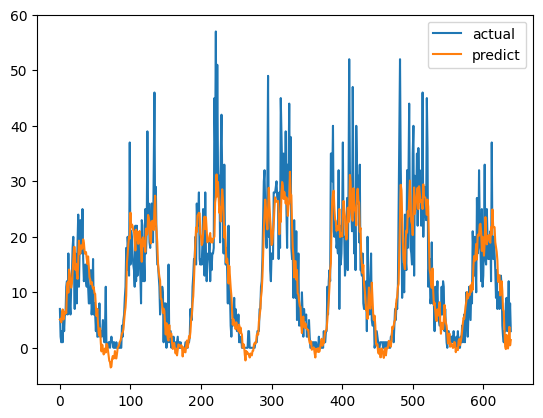

In [78]:
plt.plot(testY, label='actual')
plt.plot(testPredict, label='predict')
plt.legend()

In [72]:
modelCNN = createTemporalConvNetwork(8, 130, look_back, 130, kernel_size=3)

#modelCNN.summary()

modelCNN.compile(
    loss=MeanSquaredError(),
    optimizer=Adam(learning_rate=0.0001),
    metrics=[keras.metrics.RootMeanSquaredError()],
)

history = modelCNN.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_val, y_val),
    epochs=500,
    batch_size=32,
    #makes the training stop early if it notices no improvements on the validation set 10 times in a row, to prevent overfitting
    callbacks=[keras.callbacks.EarlyStopping(patience=5)],
)

# make predictions
trainPredict = modelCNN.predict(x_train)
testPredict = modelCNN.predict(x_test)
#invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(y_test)

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY , trainPredict))
print(f'Train Score: {trainScore:.2f} RMSE')
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print(f'Test Score: {testScore:.2f} RMSE')

Epoch 1/500
14/14 [==============================] - 11s 635ms/step - loss: 0.9897 - root_mean_squared_error: 0.9949 - val_loss: 0.8773 - val_root_mean_squared_error: 0.9367
Epoch 2/500
14/14 [==============================] - 8s 588ms/step - loss: 0.8395 - root_mean_squared_error: 0.9162 - val_loss: 0.6159 - val_root_mean_squared_error: 0.7848
Epoch 3/500
14/14 [==============================] - 8s 578ms/step - loss: 0.4556 - root_mean_squared_error: 0.6750 - val_loss: 0.5122 - val_root_mean_squared_error: 0.7157
Epoch 4/500
14/14 [==============================] - 8s 588ms/step - loss: 0.3843 - root_mean_squared_error: 0.6199 - val_loss: 0.2796 - val_root_mean_squared_error: 0.5287
Epoch 5/500
14/14 [==============================] - 8s 595ms/step - loss: 0.3165 - root_mean_squared_error: 0.5626 - val_loss: 0.2820 - val_root_mean_squared_error: 0.5310
Epoch 6/500
14/14 [==============================] - 8s 569ms/step - loss: 0.2847 - root_mean_squared_error: 0.5335 - val_loss: 0.2715

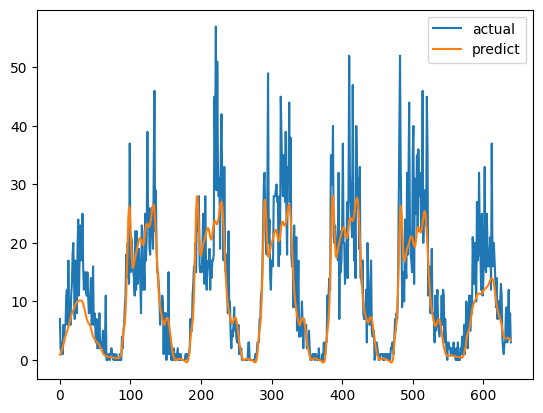

In [73]:
plt.plot(testY[:,0], label='actual')
plt.plot(testPredict[:,0], label='predict')
plt.legend()